In [1]:
import pybeads
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
DIR_BASE = os.path.abspath('')
DIR_INPUT = os.path.join(DIR_BASE, 'input')
fname = 'chromatograms_and_noise.csv'

In [3]:
df_input = pd.read_csv(os.path.join(DIR_INPUT, fname), header=None, comment='#')

In [4]:
y = df_input[3] + df_input[8]
y.head()

0    -2.172524
1    -5.777806
2    -3.444036
3    10.785754
4     2.072154
dtype: float64

In [5]:
noise_range = (0, 200)

(0.0, 200.0)

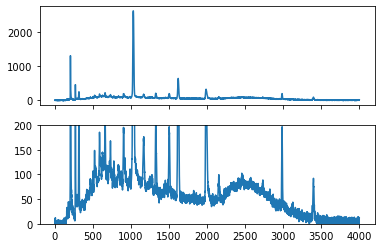

In [6]:
fig, axes = plt.subplots(2, 1, facecolor='white', dpi=72, sharex = True)
axes[0].plot(y)
axes[1].plot(y)
axes[1].set_ylim(noise_range)

In [7]:
fc = 0.006 # ハイパスフィルター作成に使うcutoff周波数
d = 1 # ハイパスフィルター作成時のパラメータ。1でよい。詳細は論文参照。
r = 6 # 非対称ペナルティの非対称具合

# 測定データとその微分にかかる正規化パラメータ
amp = 0.8
lam0 = 0.5 * amp
lam1 = 5 * amp
lam2 = 4 * amp
# MMアルゴリズムのループ回数
Nit = 15
# ペナルティー関数
pen = 'L1_v2'

y = y.to_numpy()

In [8]:
def _get_result_figure(y):
    # fitting
    signal_est, bg_est, cost = pybeads.beads(y, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)

    fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
    fig.subplots_adjust(hspace=0)
    fig.patch.set_color('white')
    axes[0].plot(y, c='k', label='original data')
    axes[0].plot(bg_est, c='r', label='BG estimated by BEADS')
    axes[0].legend()
    axes[0].set_ylim(-20, 350)
    axes[0].set_xlim(0, len(y))

    axes[1].plot(signal_est, label='signal estimated by BEADS')
    axes[1].legend()
    axes[1].set_ylim(-20, 350)
    axes[2].plot(y-signal_est-bg_est, label='noise estimated by BEADS')
    axes[2].set_ylim(-35, 35)
    axes[2].legend()

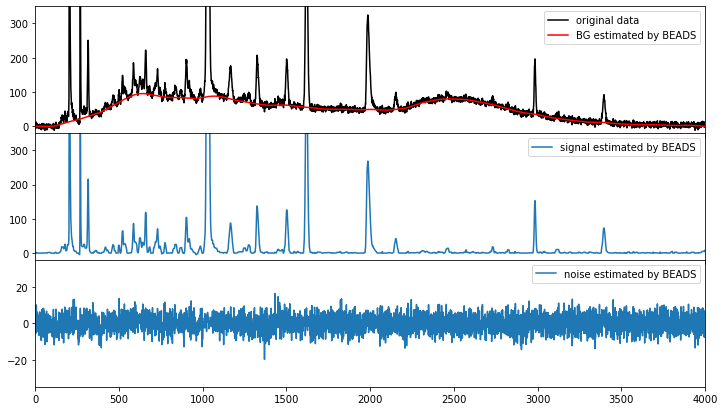

In [9]:
_get_result_figure(y)

## 端っこが0からズレると端の部分でうまくいかない

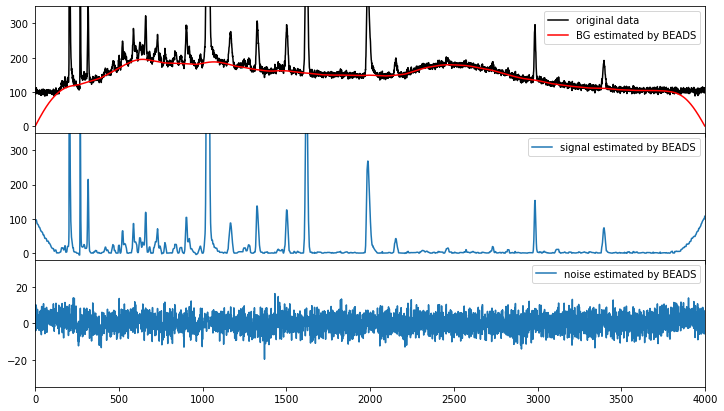

In [10]:
_get_result_figure(y+100)

## シグモイド関数を使って端っこがゼロになるようになめらかに延長してあげればいい．

In [11]:
class pybeads_transformer:
    def __init__(self, dx=0.5):
        self.xscale_l = 30
        self.xscale_r = 30
        self.dx = dx
        

    def _sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def transform(self, y):
        y = self._check_y(y)
        # 蛇足を生成
        # 左
        _l_arange = np.arange(-5*self.xscale_l, 5*self.xscale_l, self.dx)
        _l_redundant = y[0] * self._sigmoid(1/self.xscale_l * _l_arange)
        # 右
        _r_arange = np.arange(-5*self.xscale_r, 5*self.xscale_r, self.dx)
        _r_redundant = y[-1] * self._sigmoid(-1/self.xscale_r * _r_arange)
        # くっつける
        y_redundant = np.hstack([_l_redundant, y, _r_redundant])
        self.l = len(_l_arange)
        self.r = len(_r_arange)
        return y_redundant
    
    def inverse_transform(self, y_redundant):
        y_redundant = self._check_y(y_redundant)
        return y_redundant[self.l:-self.r]

    def _check_y(self, y):
        y = np.array(y)
        if len(np.array(y).shape) != 1:
            raise TypeError('1-d array only.')
        return y

In [12]:
pbdtf = pybeads_transformer()

### シグモイド関数の形

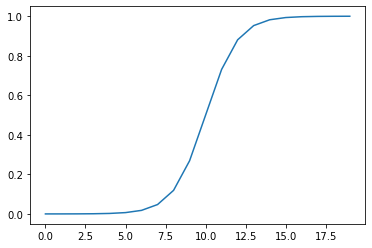

In [13]:
fig, ax = plt.subplots(facecolor = 'white')
ax.plot(pbdtf._sigmoid(np.arange(-10, 10)))

In [14]:
y_redundant = pbdtf.transform(y+100)
signal_est, bg_est, cost = pybeads.beads(y_redundant, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)

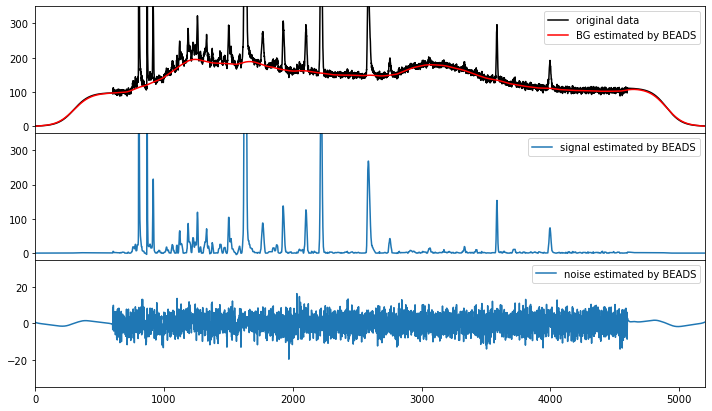

In [15]:
_get_result_figure(y_redundant)

該当部分のみ取り出す

In [16]:
pbdtf.inverse_transform(signal_est)

array([0.51198509, 0.5124693 , 2.67385677, ..., 0.91471014, 1.83576019,
       2.75310195])